In [23]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from openpyxl import load_workbook

# set environment variables
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [7]:
# data path
data_path = os.path.join(os.getcwd(), 'data')

# load the data
df_cleaned_reactions = pd.read_csv(os.path.join(data_path, 'cleaned_reactions.csv'))
df_cleaned_reaction_types = pd.read_csv(os.path.join(data_path, 'cleaned_reaction_types.csv'))
df_cleaned_contents = pd.read_csv(os.path.join(data_path, 'cleaned_contents.csv'))

# merge the data
df_sub1 = pd.merge(df_cleaned_reactions, df_cleaned_reaction_types, on='Type')
df_merged = pd.merge(df_sub1, df_cleaned_contents, on='Content ID')

# view the data
df_merged.head()

,Content ID,Type_x,Datetime,Sentiment,Score,Type_y,Category
0,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2020-11-07 09:43:50,negative,0,photo,Studying
1,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2021-01-06 19:13:01,negative,0,photo,Studying
2,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2021-04-09 02:46:20,negative,0,photo,Studying
3,97522e57-d9ab-4bd6-97bf-c24d952602d2,dislike,2021-06-17 12:22:51,negative,10,photo,Studying
4,97522e57-d9ab-4bd6-97bf-c24d952602d2,dislike,2020-11-09 02:49:59,negative,10,photo,Studying


###  some data cleaning

In [8]:
# convert the date column to datetime
def convert_to_datetime(df, col):
    df[col] = pd.to_datetime(df[col])
    return df

# convert object to category
def convert_to_category(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    return df


df_merged.rename(columns={'Type_y': 'Content_Type', 'Type_x': 'Reaction_Type'}, inplace=True)
df_merged = df_merged.pipe(convert_to_datetime, 'Datetime').pipe(convert_to_category)

# view the data
df_merged.head()


,Content ID,Reaction_Type,Datetime,Sentiment,Score,Content_Type,Category
0,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2020-11-07 09:43:50,negative,0,photo,Studying
1,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2021-01-06 19:13:01,negative,0,photo,Studying
2,97522e57-d9ab-4bd6-97bf-c24d952602d2,disgust,2021-04-09 02:46:20,negative,0,photo,Studying
3,97522e57-d9ab-4bd6-97bf-c24d952602d2,dislike,2021-06-17 12:22:51,negative,10,photo,Studying
4,97522e57-d9ab-4bd6-97bf-c24d952602d2,dislike,2020-11-09 02:49:59,negative,10,photo,Studying


In [9]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18384 entries, 0 to 18383
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Content ID     18384 non-null  category      
 1   Reaction_Type  18384 non-null  category      
 2   Datetime       18384 non-null  datetime64[ns]
 3   Sentiment      18384 non-null  category      
 4   Score          18384 non-null  int64         
 5   Content_Type   18384 non-null  category      
 6   Category       18384 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(1)
memory usage: 419.0 KB


In [10]:
top5_categories = df_merged.groupby('Category')['Score'].sum().sort_values(ascending=False).head(5)
top5_categories

Category
travel            53935
science           53657
healthy eating    52745
animals           52443
cooking           49681
Name: Score, dtype: int64

In [35]:
# write to excel
file_path = 'data/final_data.xlsx'
top5_categories = pd.DataFrame(top5_categories).reset_index()

with pd.ExcelWriter(file_path, datetime_format="YYYY-MM-DD HH:MM:SS") as writer:
    df_merged.to_excel(writer, index=False, sheet_name='clean_merged_data')
    top5_categories.to_excel(writer, index=False, sheet_name='top5_categories')

#### EDA

In [42]:
# top 5 categories dataset
df_top5_categories = df_merged.query('Category in @top5_categories.Category')
df_top5_categories.head()

,Content ID,Reaction_Type,Datetime,Sentiment,Score,Content_Type,Category
41,9f737e0a-3cdd-4d29-9d24-753f4e3be810,disgust,2021-03-28 21:15:26,negative,0,photo,healthy eating
42,9f737e0a-3cdd-4d29-9d24-753f4e3be810,dislike,2020-06-25 17:01:58,negative,10,photo,healthy eating
43,9f737e0a-3cdd-4d29-9d24-753f4e3be810,scared,2021-02-11 04:53:56,negative,15,photo,healthy eating
44,9f737e0a-3cdd-4d29-9d24-753f4e3be810,peeking,2020-08-20 18:17:06,neutral,35,photo,healthy eating
45,9f737e0a-3cdd-4d29-9d24-753f4e3be810,peeking,2020-08-20 07:59:11,neutral,35,photo,healthy eating


In [50]:
# visualize the reactions by category
def plot_bar_chart(df, x, y, hue_col=None, title=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=x, y=y, hue=hue_col, data=df)
    ax.set_title(title)
    ax.set_ylabel(f'{y}')
    ax.set_xlabel(f'{x}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    sns.despine()

def plot_pie_chart(df, col, title=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    df[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
    ax.set_title(title)


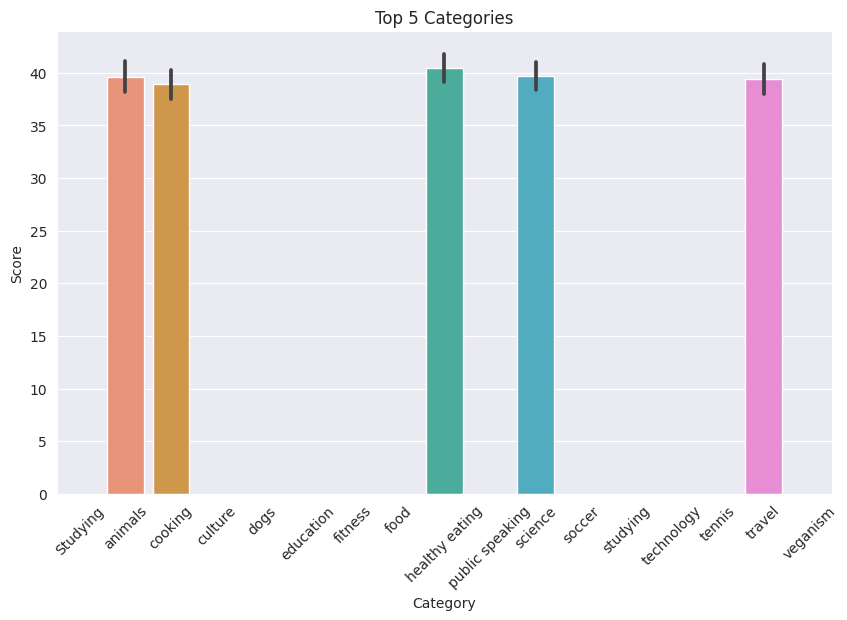

In [48]:
# plot the bar chart for the top 5 categories
plot_bar_chart(df_top5_categories, 'Category', 'Score', title='Top 5 Categories')

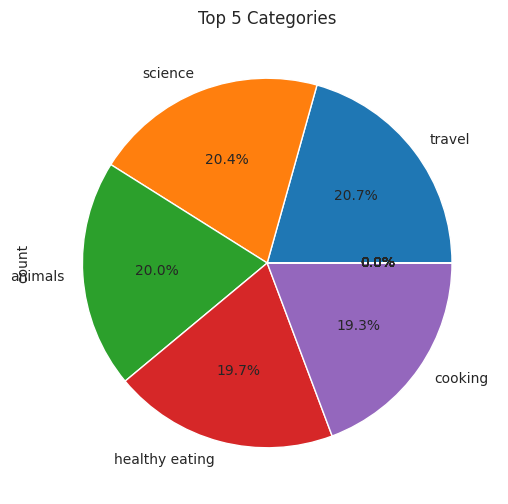

In [51]:
# plot the pie chart for the top 5 categories
plot_pie_chart(df_top5_categories, 'Category', title='Top 5 Categories')

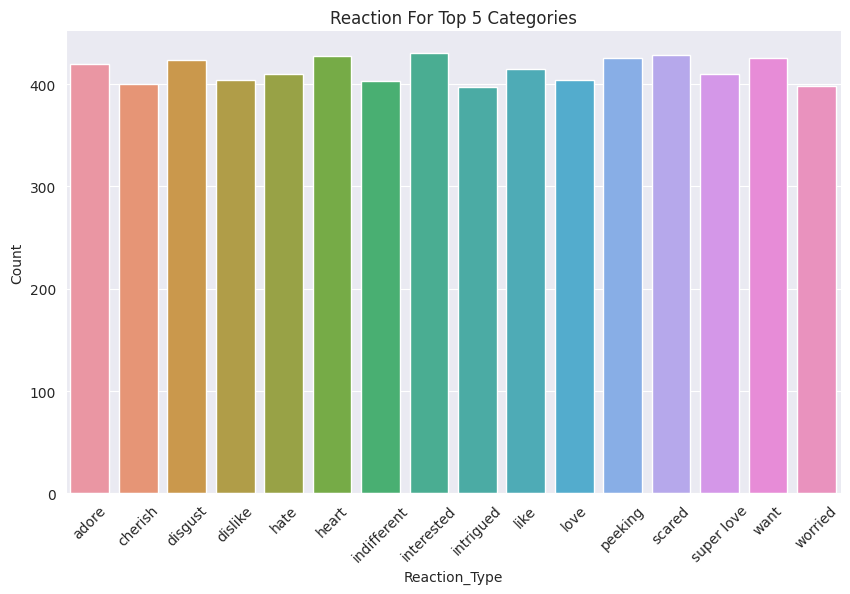

In [54]:
# visualize reactions in the top 5 categories
def plot_countplot(df, x, title=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel(f'{x}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    sns.despine()

# plot the countplot for the top 5 categories
plot_countplot(df_top5_categories, 'Reaction_Type', title='Reaction For Top 5 Categories')

In [ ]:
# months with the most categories
df_top5_categories['Month'] = df_top5_categories['Datetime'].dt.month
df_top5_categories['Year'] = df_top5_categories['Datetime'].dt.year
df_top5_categories['Month_Year'] = df_top5_categories['Datetime'].dt.to_period('M')


In [57]:
top_months = df_top5_categories.groupby('Month_Year')['Score'].sum().sort_values(ascending=False).head(5)
top_months

Month_Year
2021-05    23747
2021-04    22635
2020-12    22609
2020-10    22357
2020-09    22229
Freq: M, Name: Score, dtype: int64

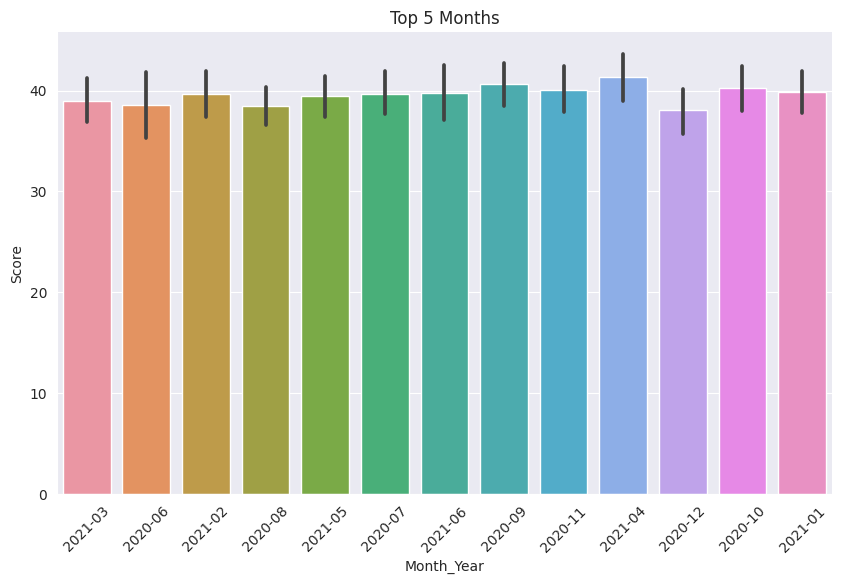

In [58]:
# plot the bar chart for the top 5 months
plot_bar_chart(df_top5_categories, 'Month_Year', 'Score', title='Top 5 Months')

In [59]:
# print reaction types for the top 5 categories
df_top5_categories['Reaction_Type'].value_counts()

Reaction_Type
interested     430
scared         428
heart          427
peeking        426
want           426
disgust        424
adore          420
like           415
hate           410
super love     410
dislike        404
love           404
indifferent    403
cherish        400
worried        398
intrigued      397
Name: count, dtype: int64